In [1]:
"""
Author: Isaac Roberts (Jay)
Employer: University of Bielefeld
Research Group: Machine Learning Group (HammerLab)


Overview: This notebook contains the code to conduct the Section 5.1 of the "Targeted Visualization of 
          the Backbone of Encoder LLMs" paper. 

"""

'\nAuthor: Isaac Roberts (Jay)\nEmployer: University of Bielefeld\nResearch Group: Machine Learning Group (HammerLab)\n\n\nOverview: This notebook contains the code to conduct the Section 5.1 of the "Targeted Visualization of \n          the Backbone of Encoder LLMs" paper. \n\n'

In [ ]:

#Import functions from Multi_task model code files
from NLP_helper_scripts.Multi_Task_Data_load import *
from NLP_helper_scripts.Multi_Task_model import *
from transformers import AutoTokenizer


# multi task model arguments 
model_args = ModelArguments(model_name_or_path="bert-base-uncased")

# multi task training arguments 
training_args = TrainingArguments(
    do_train=True,
    do_eval=True,
    output_dir="./models/mrpc_cola_rte/5epoch_bert",
    learning_rate=2e-5,
    num_train_epochs=5,
    overwrite_output_dir=True,
    remove_unused_columns=False,
)

# multi task model tokenizer 
multi_tokenizer = AutoTokenizer.from_pretrained(
    model_args.model_name_or_path,
    cache_dir=model_args.cache_dir,
    use_fast=model_args.use_fast_tokenizer,
    revision=model_args.model_revision,
    use_auth_token=True if model_args.use_auth_token else None,
)

#single task model tokenizer

# we should make sure that the tokenizers are the same. Results do not very if we do use another
# tokenizer but they can vary slightly
single_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


#use this to dictate which Glue Task to examine for the single task model
task = "sst2"


In [ ]:
from safetensors.torch import load_model

# GPU device 
device = torch.device("cuda:0")


# list of tasks included in the multi task model
multi_tasks = [Task(id=0, name='cola', type='glue', num_labels=2),
 Task(id=1, name='mnli', type='glue', num_labels=3),
 Task(id=2, name='mrpc', type='glue', num_labels=2),
 Task(id=3, name='qnli', type='glue', num_labels=2),
 Task(id=4, name='qqp', type='glue', num_labels=2),
 Task(id=5, name='rte', type='glue', num_labels=2),
 Task(id=6, name='sst2', type='glue', num_labels=2)]


# Calling the class of the multi task model and putting it on our GPU device selected above
multi_model = MultiTaskModel(model_args.model_name_or_path, tasks=multi_tasks).to(device)

# Grabs the weights from the checkpoint you select
load_model(multi_model,"./models/multi-task-model/checkpoint-350000/model.safetensors")

In [9]:
# putting the data from HF into memory 
from datasets import load_dataset
from evaluate import load
import pandas as pd
actual_task = "mnli" if task == "mnli-mm"else task
dataset = load_dataset("glue", actual_task)
metric = load("glue", actual_task)

In [10]:
#dictionary of fields by Glue task
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mnli-mm": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}

#filtering the fields to the task selected above
sentence1_key, sentence2_key = task_to_keys[task]

#test by printing to make sure you have selected the right dataset
if sentence2_key is None:
    print(f"Sentence: {dataset['train'][0][sentence1_key]}")
else:
    print(f"Sentence 1: {dataset['train'][0][sentence1_key]}")
    print(f"Sentence 2: {dataset['train'][0][sentence2_key]}")


# functions to tokenize the inputs

#multi task model tokenize
def multi_preprocess_function(examples):
    if sentence2_key is None:
       return  multi_tokenizer(examples[sentence1_key], max_length=128,padding='max_length',truncation=True)
    return multi_tokenizer(examples[sentence1_key], examples[sentence2_key], max_length=128,padding='max_length',truncation=True)


# single task model tokenize
def single_preprocess_function(examples):
    if sentence2_key is None:
       return  single_tokenizer(examples[sentence1_key], max_length=128,padding='max_length',truncation=True)
    return single_tokenizer(examples[sentence1_key], examples[sentence2_key], max_length=128,padding='max_length',truncation=True)

Sentence: hide new secretions from the parental units 


In [11]:
# mapping the functions to each portion of the datasets: train, validation
multi_preprocessed_dataset = dataset.map(multi_preprocess_function, batched=True)
single_preprocessed_dataset = dataset.map(single_preprocess_function, batched=True)

In [12]:
from NLP_helper_scripts.getData import prepare_label

validation_key = (
    "validation_mismatched"
    if task == "mnli-mm"
    else "validation_matched"
    if task == "mnli"
    else "validation"
)


#encoding the data into numpy
def bert_glue_encode(dataset):
    # Convert batch of encoded features to numpy array.
    input_ids = np.array(dataset["input_ids"], dtype="int32")
    attention_masks = np.array(dataset["attention_mask"], dtype="int32")
    token_type_ids = np.array(dataset["token_type_ids"], dtype="int32")
    labels = np.array(dataset["label"], dtype="int32")

    #add check for test set since they may not have labels
    return (input_ids, attention_masks, token_type_ids) ,labels

m_x_val, y_val = bert_glue_encode(multi_preprocessed_dataset[validation_key])
x_val, y_val = bert_glue_encode(single_preprocessed_dataset[validation_key])

In [13]:
import numpy as np

#setting the number of samples to examine
n_samples = 250

#random sample of indexes which we will use to filter0
sample_ids = np.random.choice(len(x_val[1]), n_samples)

In [14]:
# since our gpu does not contain a lot of memory we need to split the larger sample sizes up in order to embed
# the inputs with the multi_task model

import gc

# make sure that the num_splits divides the n_samples evenly
num_splits = 5
multi_sample = []

#this number should match the task head number
task = [ 6 for i in range(len(y_val))]

# this code splits the sample
for i in range(num_splits):
    if i != (len(range(num_splits)) - 1):
        multi_input_ids = torch.LongTensor(m_x_val[0][sample_ids][(i*int(n_samples/num_splits)):(i+1)* int(n_samples/num_splits)]).to(device)
        multi_attention_mask = torch.LongTensor(m_x_val[1][sample_ids][(i*int(n_samples/num_splits)):(i+1)* int(n_samples/num_splits)]).to(device)
        multi_token_type_ids = torch.LongTensor(m_x_val[2][sample_ids][(i*int(n_samples/num_splits)):(i+1)* int(n_samples/num_splits)]).to(device)
        multi_task_ids = torch.LongTensor(task[(i*int(n_samples/num_splits)):(i+1)* int(n_samples/num_splits)]).to(device)
    else: 
        multi_input_ids = torch.LongTensor(m_x_val[0][sample_ids][(i*int(n_samples/num_splits)):int(n_samples)]).to(device)
        multi_attention_mask = torch.LongTensor(m_x_val[1][sample_ids][(i*int(n_samples/num_splits)):int(n_samples)]).to(device)
        multi_token_type_ids = torch.LongTensor(m_x_val[2][sample_ids][(i*int(n_samples/num_splits)):int(n_samples)]).to(device)
        multi_task_ids = torch.LongTensor(task[(i*int(n_samples/num_splits)):int(n_samples)]).to(device)

    #embed the split with the multi task model
    multi_sample_embedding = multi_model.embed(multi_input_ids, multi_attention_mask, multi_token_type_ids, task_ids=multi_task_ids)

    #save to memory
    multi_sample_np = multi_sample_embedding.detach().cpu().numpy()

    #append to the list defined above
    multi_sample.append(multi_sample_np)


    #deletes the embedded sample from memeory to free it up 
    del multi_sample_embedding
    gc.collect()
    torch.cuda.empty_cache()

#rearrange the sample into its proper dimensions
multi_sample = np.array(multi_sample).reshape((n_samples,768))
multi_Y1 = y_val[sample_ids]

In [15]:
#defines the multi task classification head to use for Deepview
def pred_wrapper_multitask(x):
    softmax = torch.nn.Softmax(dim=-1)
    with torch.no_grad():
        x = np.array(x, dtype=np.float32)
        tensor = torch.from_numpy(x).to(device)

        # 4 is the id of QQP in the list given to the multi task model
        logits, loss = multi_model.output_heads[str(6)](tensor)
        probabilities = softmax(logits).detach().cpu().numpy()
    return probabilities

In [ ]:
#this codes loads the pretrained classifer and Bert models
from NLP_helper_scripts.getData import train_val_test_split, pretrained_bert_model, prepare_dataset, classifier_model, finetuned_bert_and_classifier
import tensorflow as tf

task = "sst2"
#path to model
saved_pretrained_classifier_only_path = './models/' + str(task)+ '/{}_pretrained_BERT_Classifier'.format(task.replace('/', '_'))

#loads a pre-trained bert model
pretrained_bert = pretrained_bert_model()

#loads the pre-trained model
pretrained_classifier = tf.saved_model.load(saved_pretrained_classifier_only_path)

#embeds the validation set using the pre-trained Bert model
val_embeddings  = pretrained_bert.predict(x_val, batch_size=64)

In [17]:
#creates the DeepView prediction wraper for the classifier
infer = pretrained_classifier.signatures['serving_default']
def pretrained_pred_wrapper(x):
    to_tensor = x.reshape((1,len(x),768))
    tensor = tf.constant(to_tensor, dtype = 'float32')
    init_preds = infer(tensor)
    init_preds = init_preds['output'].numpy()

    #make sure to check the number of classes in this case there are only 2
    preds = init_preds.reshape((len(x),2))
    return preds

In [ ]:
from deepview import DeepView

# grabs the sample ideas from the val;idation set for the Pretrained Deepview
pre_X1 = np.array([ val_embeddings[i] for i in sample_ids ])
pre_Y1 = np.array([ y_val[i] for i in sample_ids ])

In [19]:
import tensorflow_text as text


task = "sst2" 

#loads the fine-tuned models
saved_finetuned_whole_model_path = './models/' + str(task)+ '/{}_finetuned_BERT'.format(task.replace('/', '_'))
saved_finetuned_embed_model_path = './models/' + str(task)+ '/{}_finetuned_BERT_Embeddings'.format(task.replace('/', '_'))
saved_finetuned_predict_model_path = './models/' + str(task)+ '/{}_finetuned_BERT_Predictor'.format(task.replace('/', '_'))

bert_embed = tf.saved_model.load(saved_finetuned_embed_model_path)
predict_model = tf.saved_model.load(saved_finetuned_predict_model_path)
whole_model = tf.saved_model.load(saved_finetuned_whole_model_path)
infer1 = bert_embed.signatures["serving_default"]
print(infer1.structured_outputs)

{'tf_bert_model_1': TensorSpec(shape=(None, 768), dtype=tf.float32, name='tf_bert_model_1')}


In [20]:
#takes the samples and embeds them with the fine-tuned model
inputs = x_val[0][sample_ids]
attention = x_val[1][sample_ids]
token_type = x_val[2][sample_ids]
t = (inputs, attention, token_type)
samples = tf.constant(t)

test_embedding  = infer1(attention_masks=samples[1], input_ids=samples[0], token_type_ids=samples[2])
print(test_embedding['tf_bert_model_1'].shape)

test_embedding = test_embedding['tf_bert_model_1']

(250, 768)


In [21]:
#creating the sample for the finetuned model
fine_X1 = test_embedding.numpy()
fine_Y1 = np.array([ y_val[i] for i in sample_ids ])

# create a wrapper function for deepview
# need further preprocessing or conversion into a tensor datatype
finetuned_pred_wrapper = DeepView.create_simple_wrapper(predict_model)

In [ ]:

#--- Deep View Parameters ----
use_case = "nlp"
classes = np.arange(2)
batch_size = 64
max_samples = 500
data_shape = (768,)
resolution = 100
N = 10
lam = 1
cmap = 'tab10'
metric = 'cosine'
disc_dist = (
    False
    if lam == 1
    else True
)
# to make sure deepview.show is blocking,
# disable interactive mode
interactive = False
title = 'movie-reviews BERT'

multi_og_deepview_task_cosine = DeepView(pred_wrapper_multitask, classes, max_samples, batch_size, data_shape,
                      N, lam, resolution, cmap, interactive, title, metric=metric, disc_dist=disc_dist)

multi_og_deepview_task_cosine.add_samples(multi_sample,multi_Y1)



AttributeError: 'FigureManagerBase' object has no attribute 'window'

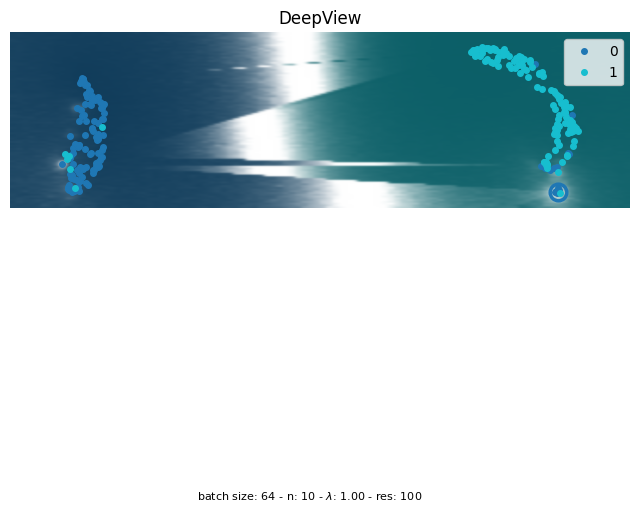

In [18]:
multi_og_deepview_task_cosine.show()

In [19]:
fine_og_deepview_task_cosine = DeepView(finetuned_pred_wrapper, classes, max_samples, batch_size, data_shape,
                      N, lam, resolution, cmap, interactive, title, metric=metric, disc_dist=disc_dist)

fine_og_deepview_task_cosine.add_samples(fine_X1,fine_Y1)


Distance calculation 20.00 %
Distance calculation 40.00 %
Distance calculation 60.00 %
Distance calculation 80.00 %
Distance calculation 100.00 %
Embedding samples ...
Computing decision regions ...
Distance calculation 20.00 %
Distance calculation 40.00 %
Distance calculation 60.00 %
Distance calculation 80.00 %
Distance calculation 100.00 %
Embedding samples ...
Computing decision regions ...


AttributeError: 'FigureManagerBase' object has no attribute 'window'

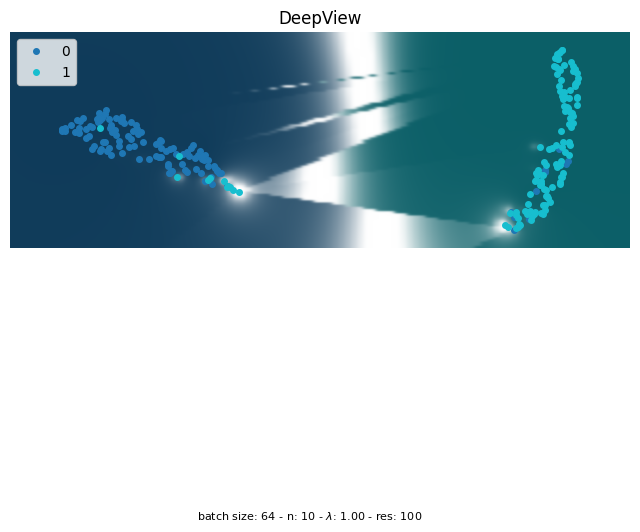

In [20]:
fine_og_deepview_task_cosine.show()

In [18]:
pre_og_deepview_task_cosine = DeepView(pretrained_pred_wrapper, classes, max_samples, batch_size, data_shape,
                      N, lam, resolution, cmap, interactive, title, metric=metric, disc_dist=disc_dist)

pre_og_deepview_task_cosine.add_samples(pre_X1,pre_Y1)

pre_og_deepview_task_half = DeepView(pretrained_pred_wrapper, classes, max_samples, batch_size, data_shape,
                      N, .5, resolution, cmap, interactive, title, metric=metric, disc_dist=True)

pre_og_deepview_task_half.add_samples(pre_X1,pre_Y1)
pre_og_deepview_task_fisher = DeepView(pretrained_pred_wrapper, classes, max_samples, batch_size, data_shape,
                      N, 0, resolution, cmap, interactive, title, metric=metric, disc_dist=True)

pre_og_deepview_task_fisher.add_samples(pre_X1,pre_Y1)

Distance calculation 20.00 %
Distance calculation 40.00 %
Distance calculation 60.00 %
Distance calculation 80.00 %
Distance calculation 100.00 %
Embedding samples ...
Computing decision regions ...
Distance calculation 20.00 %
Distance calculation 40.00 %
Distance calculation 60.00 %
Distance calculation 80.00 %
Distance calculation 100.00 %
Embedding samples ...
Computing decision regions ...


AttributeError: 'FigureManagerBase' object has no attribute 'window'

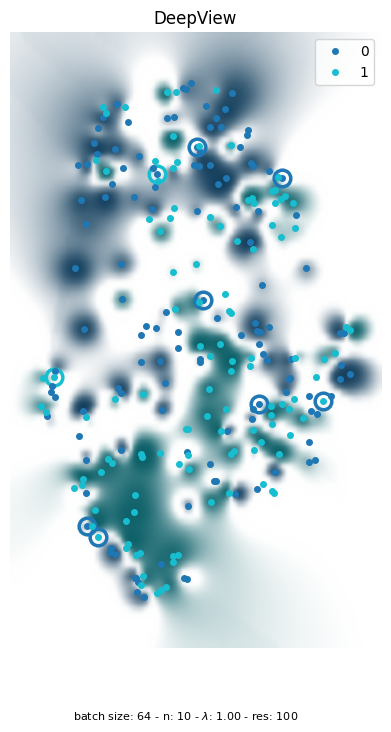

In [19]:
pre_og_deepview_task_cosine.show()

Distance calculation 20.00 %
Distance calculation 40.00 %
Distance calculation 60.00 %
Distance calculation 80.00 %
Distance calculation 100.00 %
Embedding samples ...
Computing decision regions ...


AttributeError: 'FigureManagerBase' object has no attribute 'window'

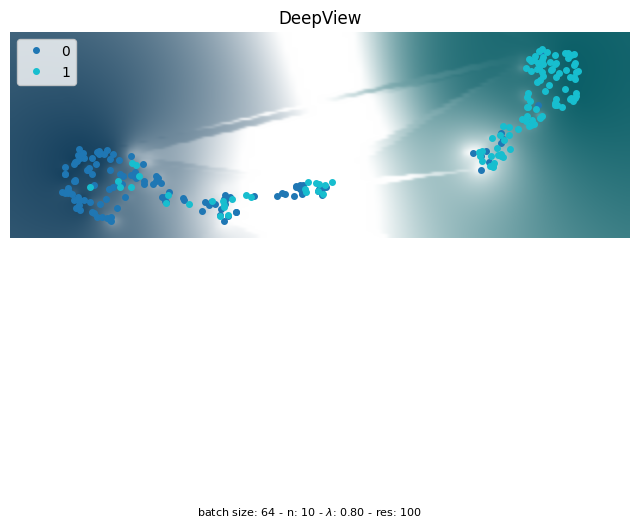

In [21]:

pre_og_deepview_task_half.show()

AttributeError: 'FigureManagerBase' object has no attribute 'window'

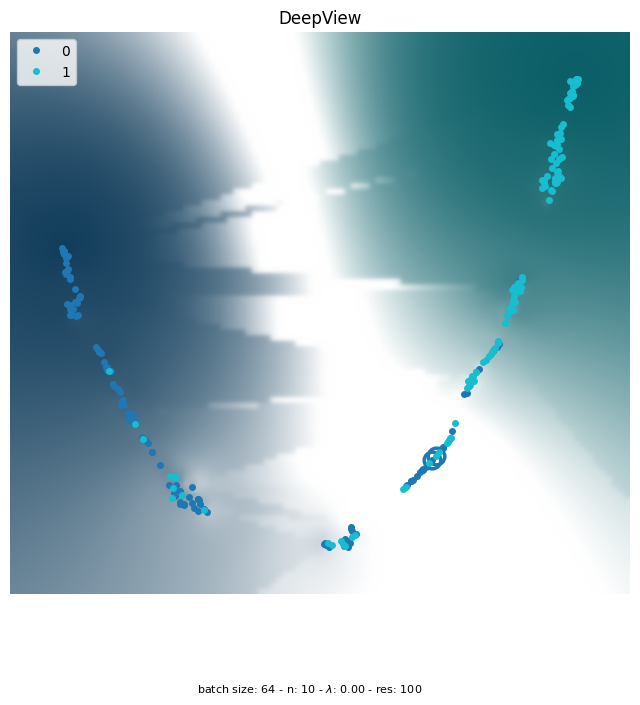

In [20]:
pre_og_deepview_task_fisher.show()

In [14]:
# this evaluates the Deepview mapping according to the Q_knn measure found in the original deepview paper

#pretrained model
from deepview.evaluate import evaluate_umap

print('Evaluation of DeepView: %s\n' % pre_og_deepview_task_fisher.title)

for l in np.linspace(0., 1., 6):
    pre_og_deepview_task_fisher.verbose = False
    pre_og_deepview_task_fisher.set_lambda(l)
    q_knn = evaluate_umap(pre_og_deepview_task_fisher, True)
    print('Lambda: %.2f - Q_kNN: %.3f' % (l, q_knn))

Evaluation of DeepView: DeepView

Lambda: 0.00 - Q_kNN: 0.004
Lambda: 0.20 - Q_kNN: 0.004
Lambda: 0.40 - Q_kNN: 0.000
Lambda: 0.60 - Q_kNN: 0.000
Lambda: 0.80 - Q_kNN: 0.004
Lambda: 1.00 - Q_kNN: 0.404


In [29]:
# this evaluates the Deepview mapping according to the Q_knn measure found in the original deepview paper

#finetuned model

print('Evaluation of DeepView: %s\n' % fine_og_deepview_task_fisher.title)

for l in np.linspace(0., 1., 6):
    fine_og_deepview_task_fisher.verbose = False
    fine_og_deepview_task_fisher.set_lambda(l)
    q_knn = evaluate_umap(fine_og_deepview_task_fisher, True)
    print('Lambda: %.2f - Q_kNN: %.3f' % (l, q_knn))

Evaluation of DeepView: DeepView

Lambda: 0.00 - Q_kNN: 0.000
Lambda: 0.20 - Q_kNN: 0.000
Lambda: 0.40 - Q_kNN: 0.000
Lambda: 0.60 - Q_kNN: 0.000
Lambda: 0.80 - Q_kNN: 0.000
Lambda: 1.00 - Q_kNN: 0.004


In [30]:
# this evaluates the Deepview mapping according to the Q_knn measure found in the original deepview paper

#multi-task model
print('Evaluation of DeepView: %s\n' % multi_og_deepview_task_fisher.title)

for l in np.linspace(0., 1., 6):
    multi_og_deepview_task_fisher.verbose = False
    multi_og_deepview_task_fisher.set_lambda(l)
    q_knn = evaluate_umap(multi_og_deepview_task_fisher, True)
    print('Lambda: %.2f - Q_kNN: %.3f' % (l, q_knn))

Evaluation of DeepView: DeepView

Lambda: 0.00 - Q_kNN: 0.000
Lambda: 0.20 - Q_kNN: 0.000
Lambda: 0.40 - Q_kNN: 0.000
Lambda: 0.60 - Q_kNN: 0.000
Lambda: 0.80 - Q_kNN: 0.000
Lambda: 1.00 - Q_kNN: 0.000


In [16]:
# this is an adaptation to the original Q_knn score 
# we instead use the true label instead of the predicted label

#pretrained model

from deepview.evaluate import leave_one_out_knn_dist_err, evaluate_inv_umap

print('Evaluation of DeepView: %s\n' % pre_og_deepview_task_fisher.title)

for l in np.linspace(0., 1., 6):
    pre_og_deepview_task_fisher.verbose = False
    pre_og_deepview_task_fisher.set_lambda(l)
    q_knn = leave_one_out_knn_dist_err(pre_og_deepview_task_fisher.distances ,pre_og_deepview_task_fisher.y_true)
    print('Lambda: %.2f - Q_kNN_true: %.3f' % (l, q_knn))

Evaluation of DeepView: DeepView

Lambda: 0.00 - Q_kNN_true: 0.140
Lambda: 0.20 - Q_kNN_true: 0.160
Lambda: 0.40 - Q_kNN_true: 0.152
Lambda: 0.60 - Q_kNN_true: 0.156
Lambda: 0.80 - Q_kNN_true: 0.156
Lambda: 1.00 - Q_kNN_true: 0.324


In [32]:
# this is an adaptation to the original Q_knn score 
# we instead use the true label instead of the predicted label

#finetuned model

print('Evaluation of DeepView: %s\n' % fine_og_deepview_task_fisher.title)

for l in np.linspace(0., 1., 6):
    fine_og_deepview_task_fisher.verbose = False
    fine_og_deepview_task_fisher.set_lambda(l)
    q_knn = leave_one_out_knn_dist_err(fine_og_deepview_task_fisher.distances ,fine_og_deepview_task_fisher.y_true)
    print('Lambda: %.2f - Q_kNN_true: %.3f' % (l, q_knn))

Evaluation of DeepView: DeepView

Lambda: 0.00 - Q_kNN_true: 0.064
Lambda: 0.20 - Q_kNN_true: 0.064
Lambda: 0.40 - Q_kNN_true: 0.060
Lambda: 0.60 - Q_kNN_true: 0.068
Lambda: 0.80 - Q_kNN_true: 0.064
Lambda: 1.00 - Q_kNN_true: 0.072


In [33]:
# this is an adaptation to the original Q_knn score 
# we instead use the true label instead of the predicted label

#multi-task model

print('Evaluation of DeepView: %s\n' % multi_og_deepview_task_fisher.title)

for l in np.linspace(0., 1., 6):
    multi_og_deepview_task_fisher.verbose = False
    multi_og_deepview_task_fisher.set_lambda(l)
    q_knn = leave_one_out_knn_dist_err(multi_og_deepview_task_fisher.distances ,multi_og_deepview_task_fisher.y_true)
    print('Lambda: %.2f - Q_kNN_true: %.3f' % (l, q_knn))

Evaluation of DeepView: DeepView

Lambda: 0.00 - Q_kNN_true: 0.080
Lambda: 0.20 - Q_kNN_true: 0.076
Lambda: 0.40 - Q_kNN_true: 0.072
Lambda: 0.60 - Q_kNN_true: 0.076
Lambda: 0.80 - Q_kNN_true: 0.072
Lambda: 1.00 - Q_kNN_true: 0.072


In [ ]:
from deepview.evaluate import evaluate_inv_umap

# in the below code, we evaluate the inverse mapping of UMAP for the three model settings 

print('Evaluation of DeepView: %s\n' % pre_og_deepview_task_fisher.title)

for l in np.linspace(0., 1., 6):
    pre_og_deepview_task_fisher.verbose = False
    pre_og_deepview_task_fisher.set_lambda(l)
    train,test = evaluate_inv_umap(pre_og_deepview_task_fisher,pre_X1,pre_Y1)
    print('Lambda: %.2f - Q_data: %.3f' % (l, test))

In [ ]:
print('Evaluation of DeepView: %s\n' % pre_og_deepview_task_fisher.title)

for l in np.linspace(0., 1., 6):
    fine_og_deepview_task_cosine.verbose = False
    fine_og_deepview_task_cosine.set_lambda(l)
    train,test = evaluate_inv_umap(fine_og_deepview_task_cosine,fine_X1,fine_Y1)
    print('Lambda: %.2f - Q_data: %.3f' % (l, test))

In [ ]:
print('Evaluation of DeepView: %s\n' % multi_og_deepview_task_cosine.title)

for l in np.linspace(0., 1., 6):
    multi_og_deepview_task_cosine.verbose = False
    multi_og_deepview_task_cosine.set_lambda(l)
    train,test = evaluate_inv_umap(multi_og_deepview_task_cosine,multi_sample,multi_Y1)
    print('Lambda: %.2f - Q_data: %.3f' % (l, test))